<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/gans/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import math
import numpy as np
from torchsummary import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [2]:
n_epochs = 200
batch_size = 64
lr = 0.00005
latent_dim  = 100
img_size = 28
channels = 1
n_critic = 5           #number of training steps for discriminator per iter
clip_value = 0.01      #lower and upper clip value for disc. weights
display_step = 5000
image_shape = (channels,img_size,img_size)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        def block(in_feats,out_feats,normalize = True):
            layers = [nn.Linear(in_feats,out_feats)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feats,0.8))
            layers.append(nn.LeakyReLU(0.2,inplace = True))
            return layers
        self.model = nn.Sequential(
            *block(latent_dim,128,normalize = False),
            *block(128,256),
            *block(256,512),
            *block(512,1024),
            nn.Linear(1024,int(np.prod(image_shape))),
            nn.Tanh()
        )
    def forward(self,z):
        img = self.model(z)
        img = img.view(img.size(0),*image_shape)
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(image_shape)),512),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(256, 1),
        )
    def forward(self,img):
        img_flat = img.view(img.size(0),-1)
        validity = self.model(img_flat)
        return validity

In [5]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [6]:
dataloader = DataLoader(
    datasets.MNIST(
        './root',
        download= True,
        train = True,
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    ),
    batch_size = batch_size,
    shuffle = True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 142724231.10it/s]

Extracting ./root/MNIST/raw/train-images-idx3-ubyte.gz to ./root/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 130674966.37it/s]


Extracting ./root/MNIST/raw/train-labels-idx1-ubyte.gz to ./root/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 92304189.48it/s]

Extracting ./root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./root/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19242958.35it/s]


Extracting ./root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./root/MNIST/raw



In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


In [8]:
images,labels = next(iter(dataloader))
show_tensor_images(images)

In [9]:
optimizer_G = torch.optim.RMSprop(generator.parameters(),lr = lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(),lr = lr)

In [10]:
from tqdm import tqdm

 33%|███▎      | 310/938 [00:07<00:11, 55.40it/s]

Epoch 5, step 5000: Generator loss: -1.638129249746913, discriminator loss: -0.7107885158108577


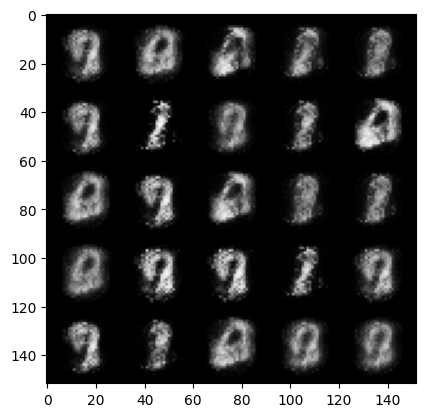

 66%|██████▌   | 618/938 [00:12<00:05, 54.79it/s]

Epoch 10, step 10000: Generator loss: -0.0822719941861927, discriminator loss: -0.299236061091721


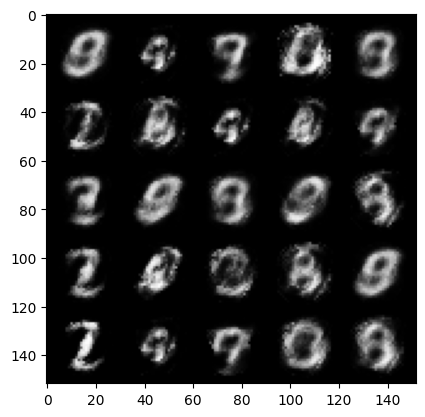

 99%|█████████▉| 929/938 [00:18<00:00, 55.88it/s]

Epoch 15, step 15000: Generator loss: -0.2760072539627545, discriminator loss: -0.30276114779710733


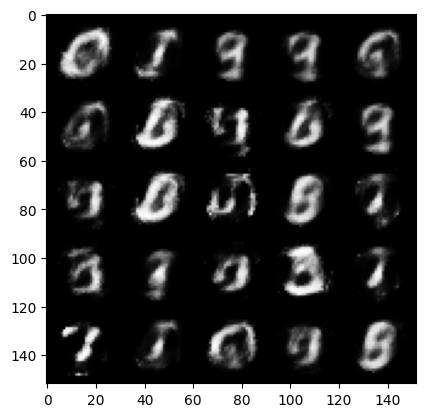

 32%|███▏      | 300/938 [00:05<00:11, 54.43it/s]

Epoch 21, step 20000: Generator loss: -0.1204632038213314, discriminator loss: -0.25459961925148955


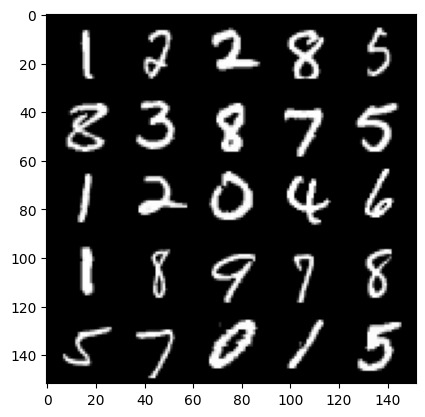

 65%|██████▍   | 607/938 [00:12<00:06, 52.56it/s]

Epoch 26, step 25000: Generator loss: -0.10440804912643505, discriminator loss: -0.23894742163121654


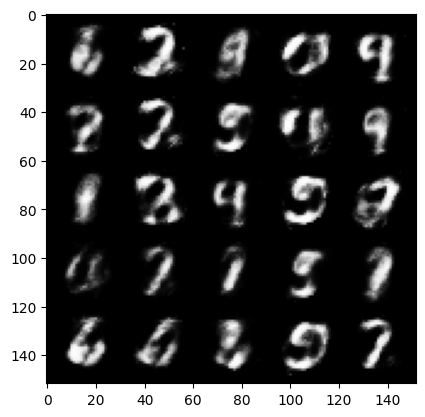

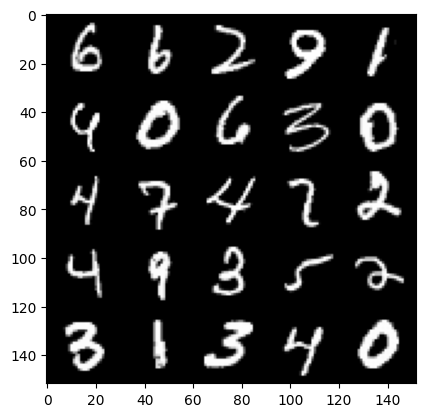

 98%|█████████▊| 921/938 [00:18<00:00, 44.39it/s]

Epoch 31, step 30000: Generator loss: -0.09065136877829198, discriminator loss: -0.24221113050282014


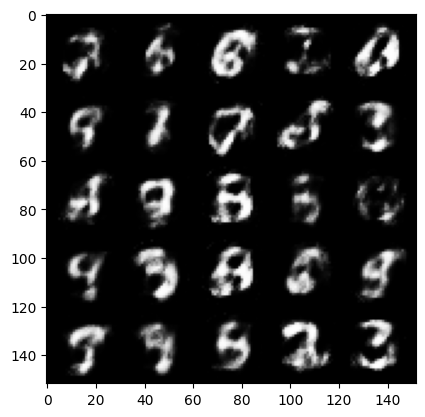

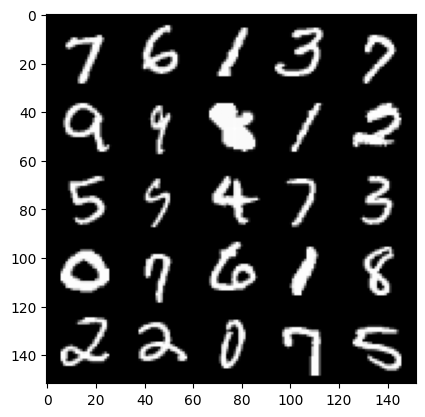

 31%|███▏      | 294/938 [00:06<00:17, 36.39it/s]

Epoch 37, step 35000: Generator loss: -0.0755587155172601, discriminator loss: -0.25716875737607425


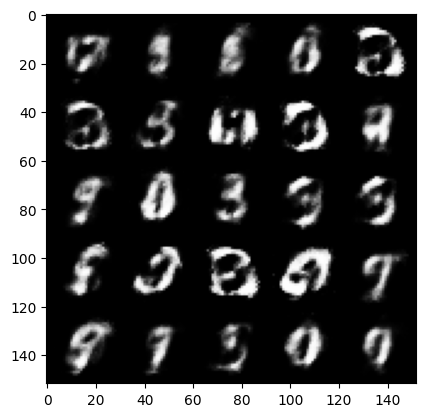

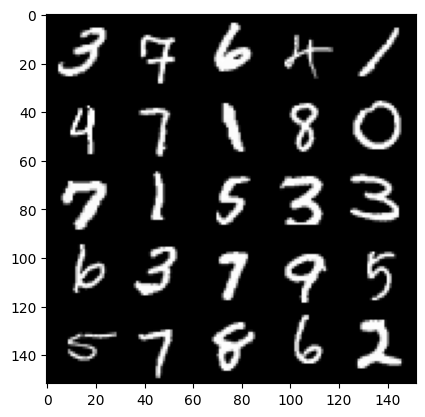

 64%|██████▍   | 602/938 [00:12<00:06, 53.62it/s]

Epoch 42, step 40000: Generator loss: -0.03119895018269308, discriminator loss: -0.2543335161000484


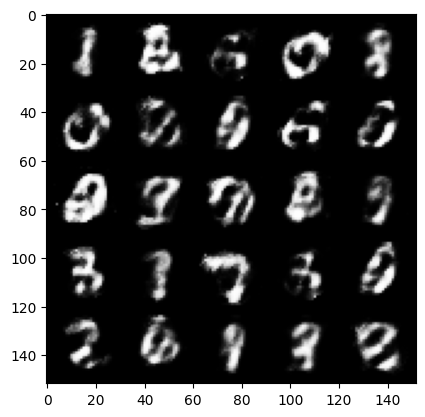

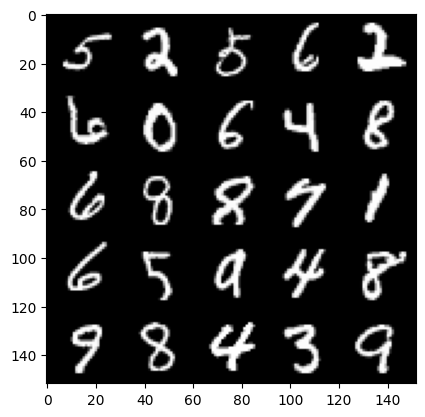

 97%|█████████▋| 911/938 [00:19<00:00, 52.50it/s]

Epoch 47, step 45000: Generator loss: -0.009683298314595603, discriminator loss: -0.24698151804506702


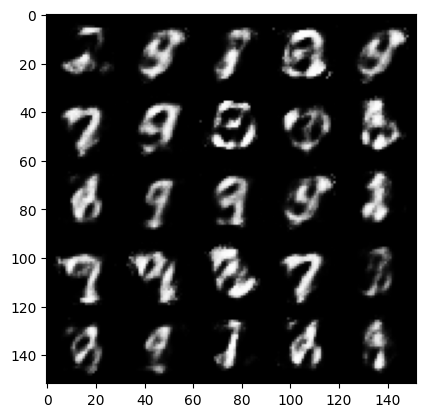

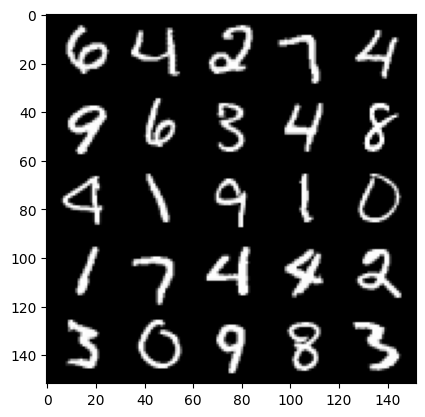

 30%|███       | 285/938 [00:05<00:13, 49.53it/s]

Epoch 53, step 50000: Generator loss: -0.06100462977066636, discriminator loss: -0.2315131855666646


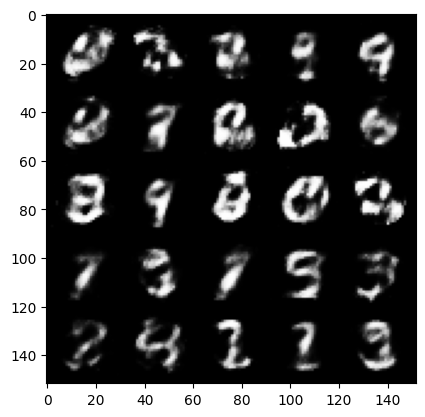

 63%|██████▎   | 593/938 [00:12<00:09, 37.34it/s]

Epoch 58, step 55000: Generator loss: -0.08497148349434129, discriminator loss: -0.21616415119469162


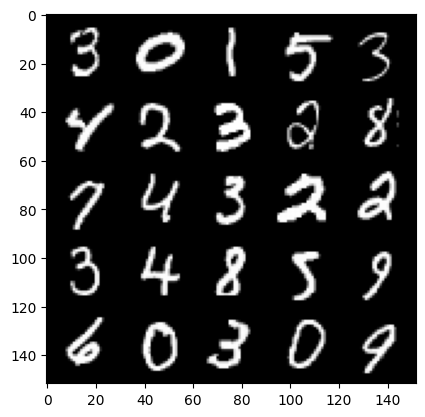

 96%|█████████▌| 901/938 [00:19<00:00, 50.92it/s]

Epoch 63, step 60000: Generator loss: -0.08552806345075371, discriminator loss: -0.19885223228335516


 29%|██▉       | 274/938 [00:05<00:13, 48.22it/s]

Epoch 69, step 65000: Generator loss: -0.07075062362551682, discriminator loss: -0.18956275779902948


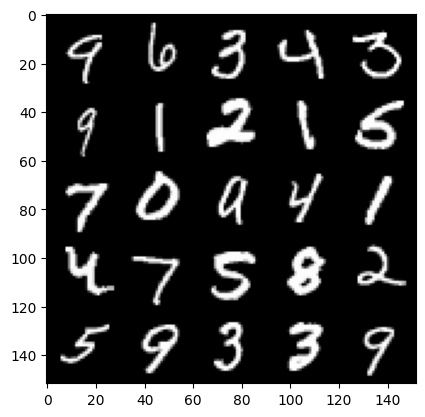

 62%|██████▏   | 585/938 [00:12<00:07, 46.75it/s]

Epoch 74, step 70000: Generator loss: -0.05907935942318295, discriminator loss: -0.18004541273415106


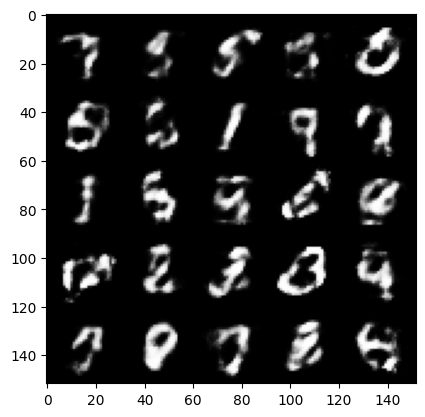

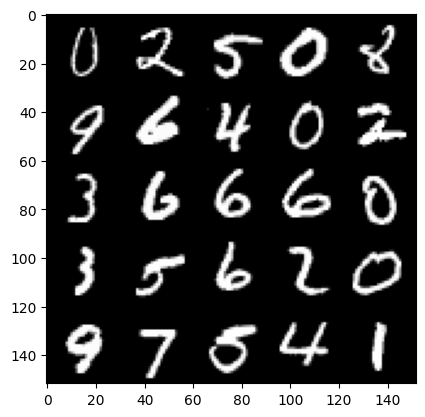

 96%|█████████▌| 898/938 [00:19<00:00, 50.30it/s]

Epoch 79, step 75000: Generator loss: -0.0505647991835139, discriminator loss: -0.17370890924483512


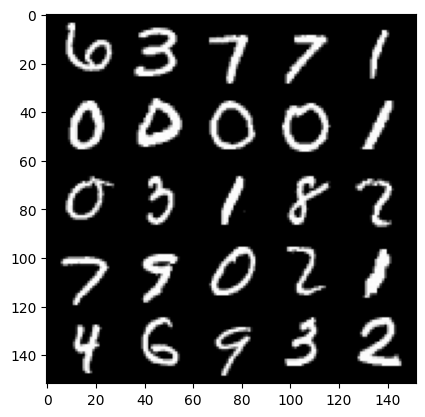

 28%|██▊       | 267/938 [00:05<00:13, 50.36it/s]

Epoch 85, step 80000: Generator loss: -0.06535815460830928, discriminator loss: -0.16628549159765274


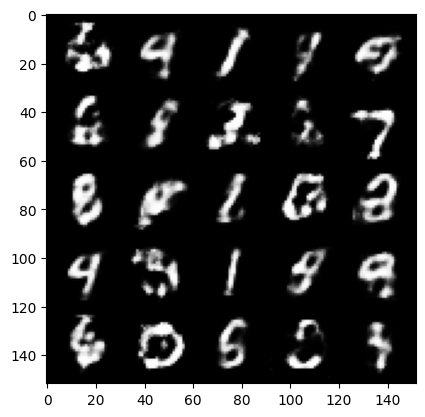

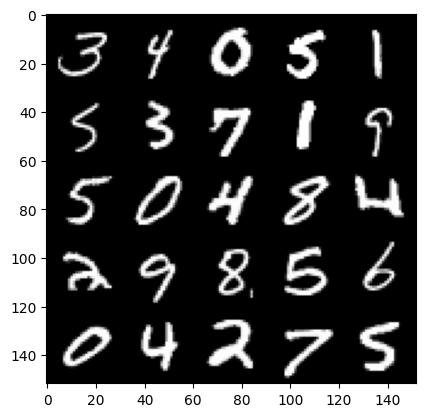

 62%|██████▏   | 577/938 [00:12<00:07, 50.58it/s]

Epoch 90, step 85000: Generator loss: -0.05073112973421813, discriminator loss: -0.1612068498164417


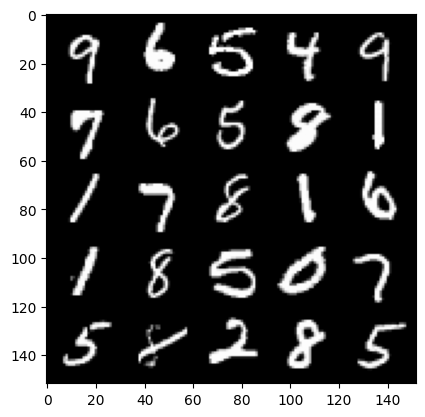

 95%|█████████▍| 890/938 [00:19<00:01, 46.37it/s]

Epoch 95, step 90000: Generator loss: -0.04919596964120868, discriminator loss: -0.15766209810823242


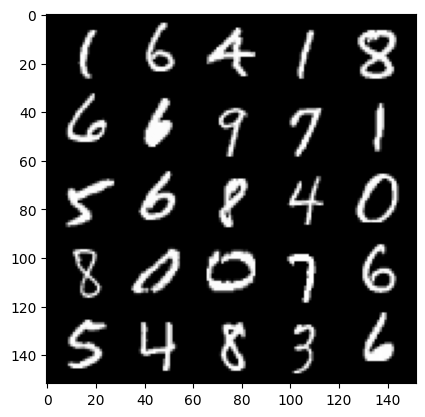

 28%|██▊       | 262/938 [00:06<00:14, 47.72it/s]

Epoch 101, step 95000: Generator loss: -0.04940294161066409, discriminator loss: -0.15022621973901976


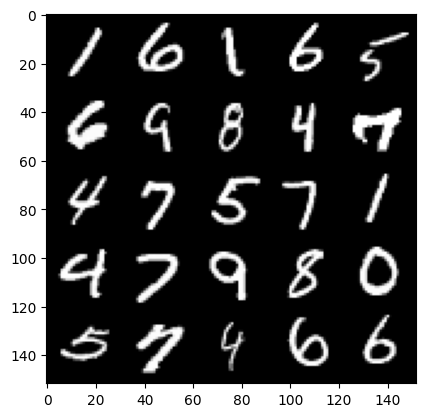

 61%|██████    | 569/938 [00:12<00:11, 31.72it/s]

Epoch 106, step 100000: Generator loss: -0.043457986821048, discriminator loss: -0.1438731864869594


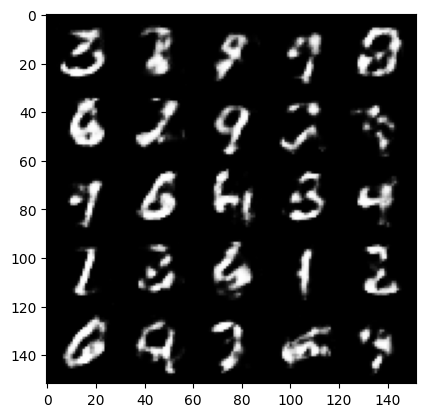

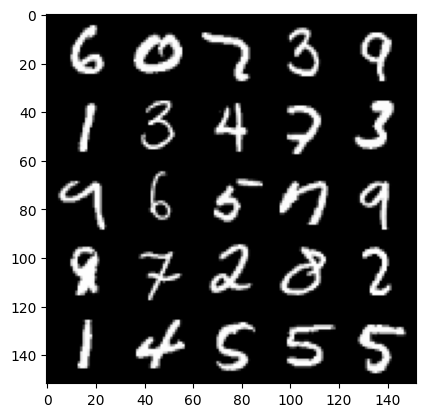

 94%|█████████▍| 880/938 [00:19<00:01, 48.42it/s]

Epoch 111, step 105000: Generator loss: -0.045524779340252265, discriminator loss: -0.13797084037810606


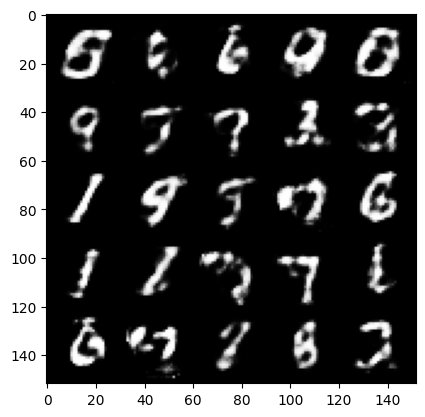

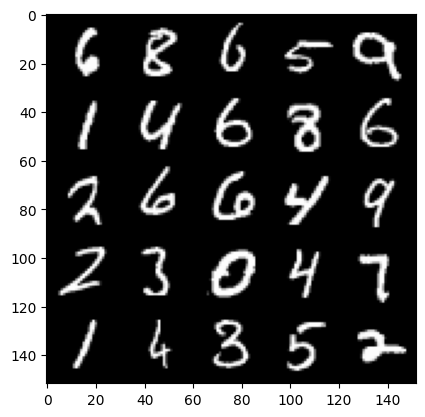

 27%|██▋       | 254/938 [00:06<00:14, 46.42it/s]

Epoch 117, step 110000: Generator loss: -0.04432207682640293, discriminator loss: -0.13261360536962694


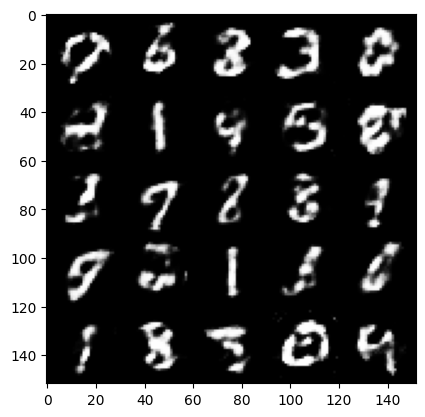

 60%|█████▉    | 562/938 [00:13<00:08, 45.90it/s]

Epoch 122, step 115000: Generator loss: -0.04920639171004297, discriminator loss: -0.12617167423665515


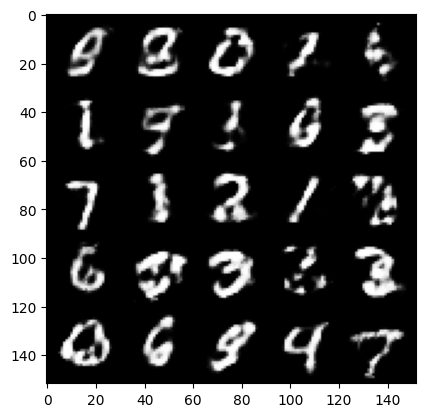

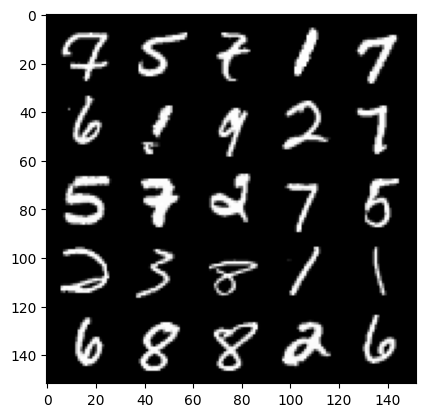

 93%|█████████▎| 870/938 [00:20<00:01, 45.68it/s]

Epoch 127, step 120000: Generator loss: -0.04098072067946194, discriminator loss: -0.12252028744518782


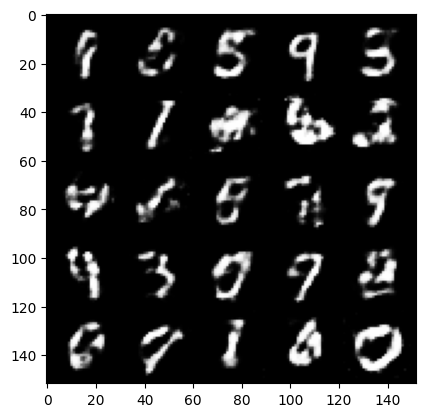

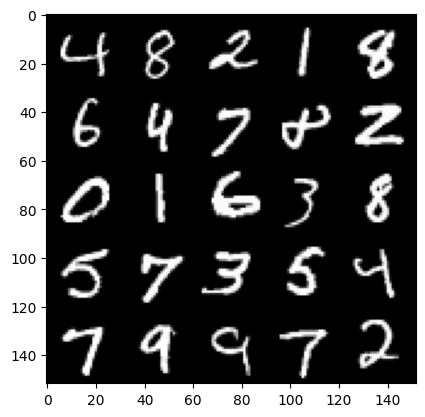

 26%|██▌       | 242/938 [00:06<00:14, 47.68it/s]

Epoch 133, step 125000: Generator loss: -0.050133199018239934, discriminator loss: -0.11669998332262062


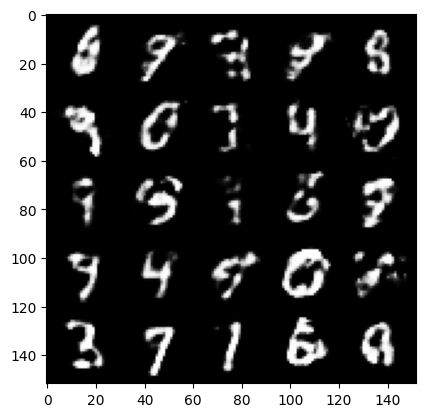

 59%|█████▉    | 555/938 [00:13<00:08, 45.96it/s]

Epoch 138, step 130000: Generator loss: -0.04727666491428395, discriminator loss: -0.11324790910482407


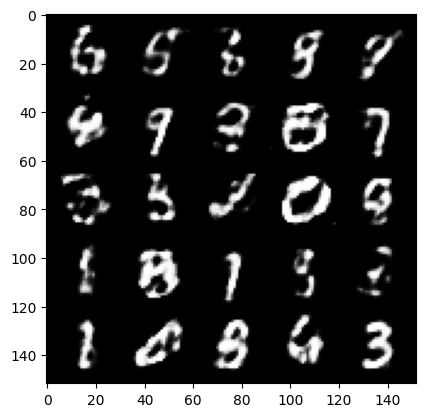

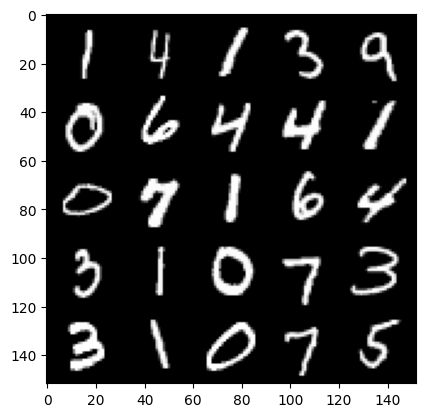

 92%|█████████▏| 862/938 [00:21<00:01, 43.28it/s]

Epoch 143, step 135000: Generator loss: -0.048223974860645884, discriminator loss: -0.11054182754457034


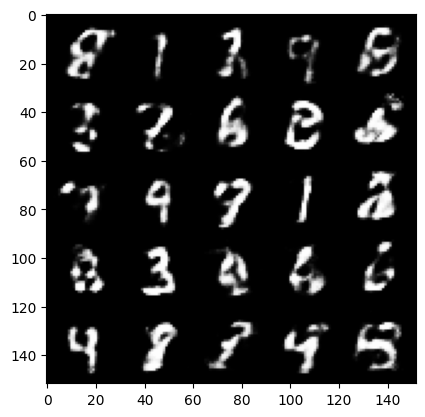

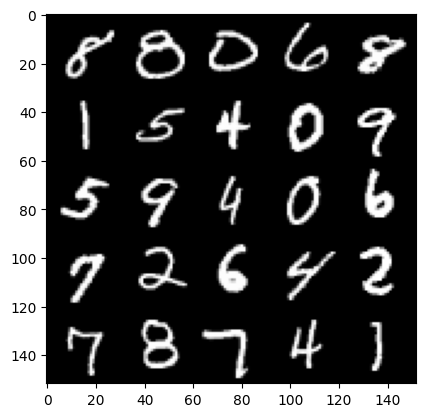

 25%|██▌       | 235/938 [00:06<00:16, 43.37it/s]

Epoch 149, step 140000: Generator loss: -0.05154996701553468, discriminator loss: -0.1065759466513991


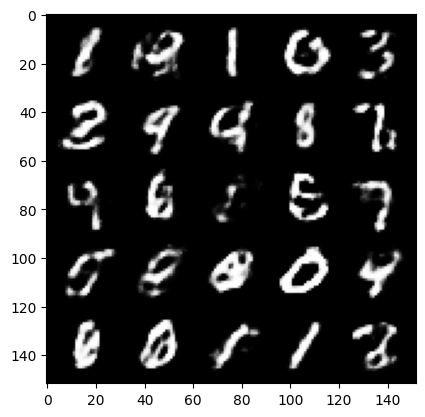

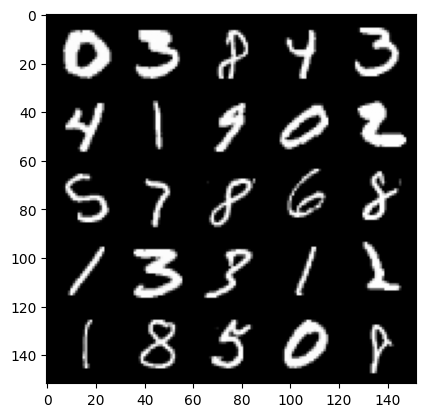

 58%|█████▊    | 548/938 [00:13<00:08, 44.35it/s]

Epoch 154, step 145000: Generator loss: -0.05575260292738672, discriminator loss: -0.1030163655593994


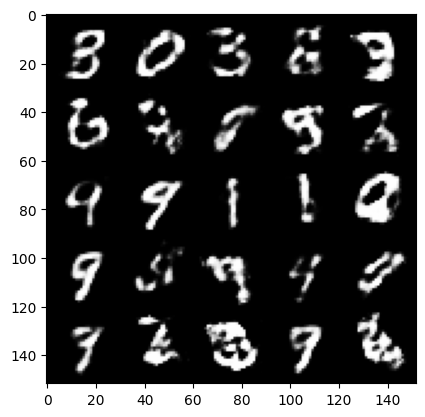

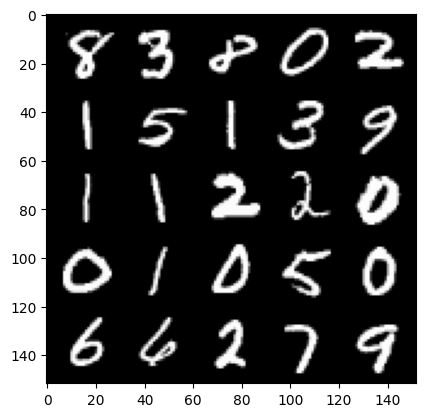

 91%|█████████▏| 857/938 [00:21<00:01, 42.18it/s]

Epoch 159, step 150000: Generator loss: -0.048330784504488106, discriminator loss: -0.10037800436913984


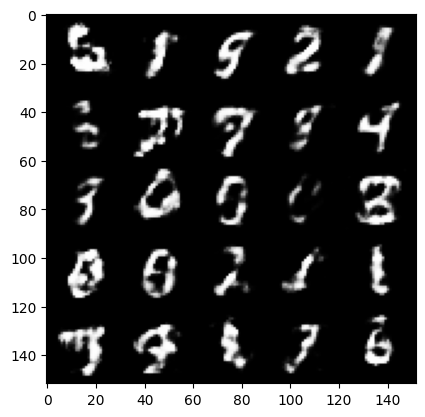

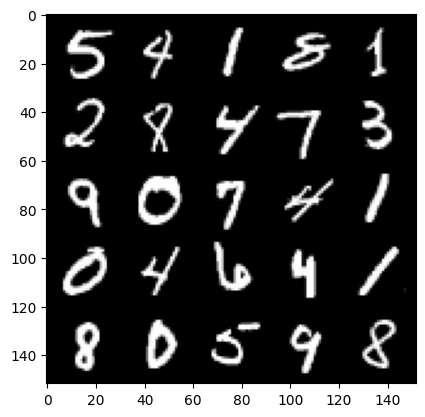

 24%|██▍       | 229/938 [00:06<00:24, 29.06it/s]

Epoch 165, step 155000: Generator loss: -0.050980594396591195, discriminator loss: -0.09802180639654352


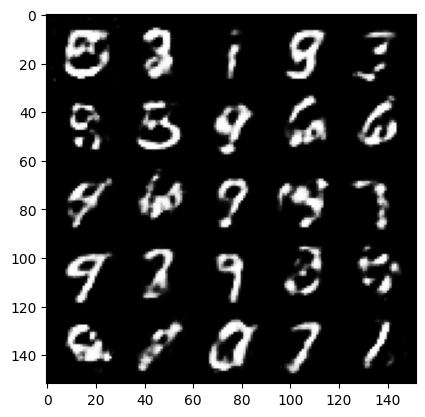

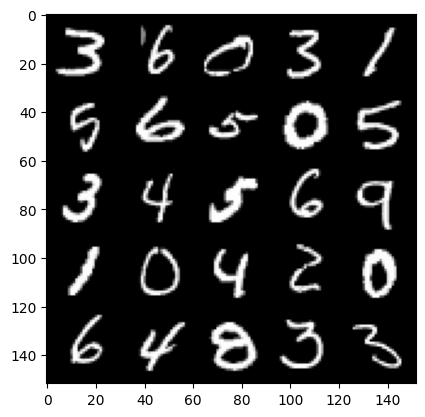

 57%|█████▋    | 536/938 [00:13<00:10, 37.51it/s]

Epoch 170, step 160000: Generator loss: -0.05122766064889728, discriminator loss: -0.09581837927997097


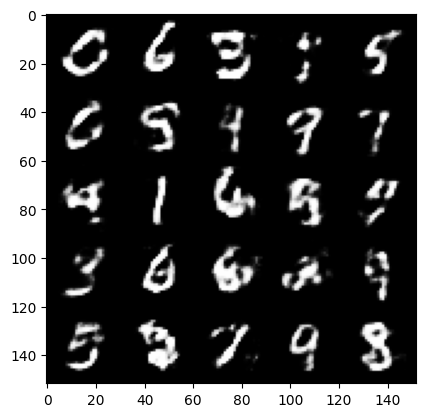

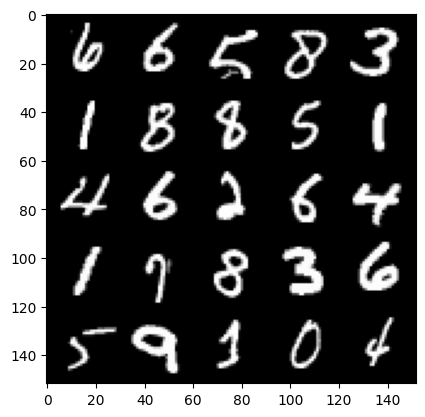

 90%|█████████ | 846/938 [00:21<00:02, 42.64it/s]

Epoch 175, step 165000: Generator loss: -0.059614800627529566, discriminator loss: -0.09201576426029198


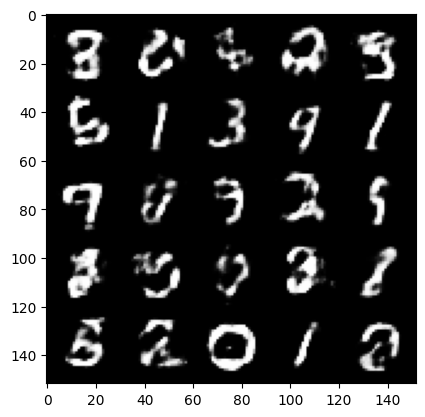

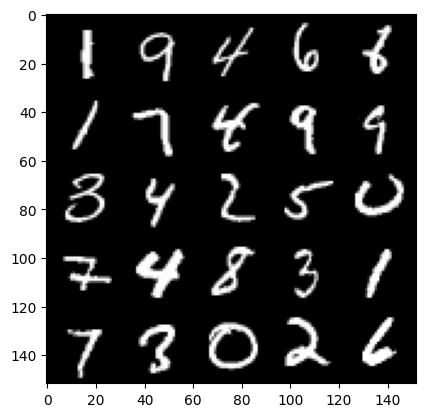

 23%|██▎       | 219/938 [00:05<00:23, 30.65it/s]

Epoch 181, step 170000: Generator loss: -0.05147478813901543, discriminator loss: -0.08935170626640314


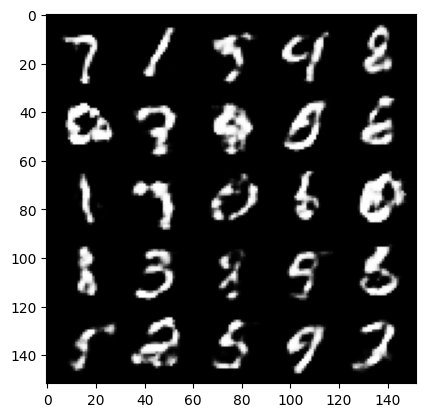

 57%|█████▋    | 532/938 [00:13<00:09, 41.55it/s]

Epoch 186, step 175000: Generator loss: -0.053294521476328315, discriminator loss: -0.08663042618483284


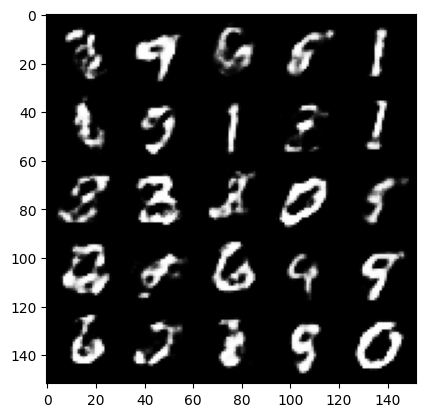

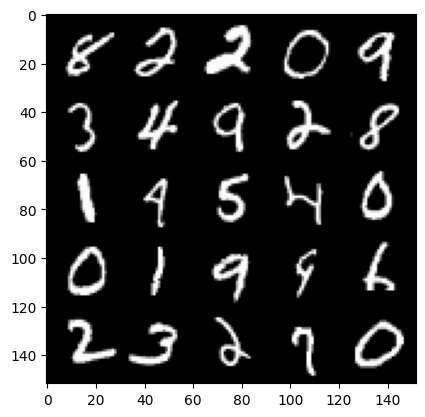

 90%|████████▉ | 841/938 [00:22<00:02, 40.82it/s]

Epoch 191, step 180000: Generator loss: -0.06047839891314504, discriminator loss: -0.08450361724197851


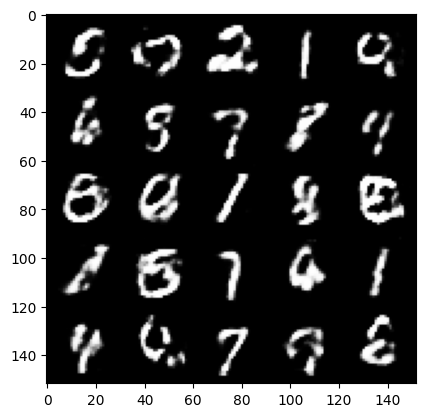

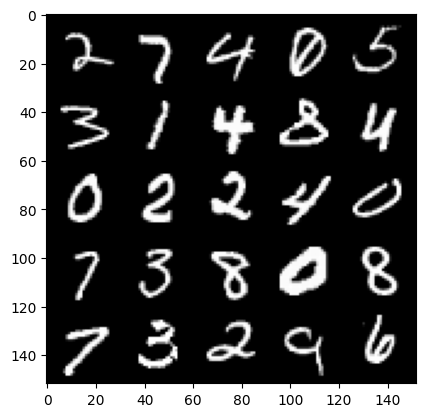

 23%|██▎       | 214/938 [00:06<00:20, 34.54it/s]

Epoch 197, step 185000: Generator loss: -0.05866004234999414, discriminator loss: -0.08239803224205988


100%|██████████| 938/938 [00:25<00:00, 36.86it/s]


In [11]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for i,(imgs,_) in enumerate(tqdm(dataloader)):
        real_imgs = imgs.to(device)

        #-------------------------
        # Train Discriminator
        #-------------------------
        optimizer_D.zero_grad()

        #sample noise for generator input
        z = torch.normal(0,1,(real_imgs.size(0),latent_dim)).to(device)

        # Generate a batch of images
        fake_imgs = generator(z).detach()

        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        #clip weights for discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value,clip_value)

        # Keep track of the average discriminator loss
        mean_discriminator_loss += loss_D.item() / display_step


        # Train the generator every n_critic iterations
        if i % n_critic == 0:
            #----------------
            #Train Generator
            #---------------
            optimizer_G.zero_grad()

            # Generate a batch of images
            generated_imgs = generator(z)

            #adversarial_loss
            loss_G = -torch.mean(discriminator(generated_imgs))

            loss_G.backward()
            optimizer_G.step()

            # Keep track of the average generator loss
            mean_generator_loss += loss_G.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

            show_tensor_images(generated_imgs)
            show_tensor_images(real_imgs)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
